# Reinforcement Learning

# 7. Parametric Bandits

The objective of this lab is to recommend contents (here movies) using **parametric bandits**. The rewards are binary (like or dislike).


## Imports

In [1]:
import numpy as np
import pandas as pd

You will need ``ipywidgets`` to simulate the interactions with the user.

In [ ]:
#!pip install ipywidgets

In [8]:
from ipywidgets import AppLayout, Button, GridspecLayout, Image, Layout

In [ ]:
#!pip install scikit-learn

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer

In [9]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

## Data

We work on a catalogue of 1037 movies available in 2015.

In [3]:
catalogue = pd.read_pickle('movie_database.pickle')

In [4]:
len(catalogue)

1037

In [9]:
catalogue.head()

,Actors,Awards,Country,Director,Genre,Language,Rated,Released,Title,imdbID,imdbRating,Metascore,Box_office,imdbVotes,Runtime,poster
0,"[Mark Hamill, Harrison Ford, Carrie Fisher, Bi...",Won 1 Oscar. Another 15 wins & 18 nominations.,[USA],[Irvin Kershner],"[Action, Adventure, Fantasy]",[English],[PG],1980-06-20,Star Wars: Episode V - The Empire Strikes Back,tt0080684,8.8,79.0,290158751.0,799579.0,124.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,"[Kareem Abdul-Jabbar, Lloyd Bridges, Peter Gra...",Nominated for 1 Golden Globe. Another 2 wins &...,[USA],"[Jim Abrahams, David Zucker, Jerry Zucker]",[Comedy],[English],[PG],1980-07-02,Airplane!,tt0080339,7.8,NaN,83400000.0,154994.0,88.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,"[John Belushi, Dan Aykroyd, James Brown, Cab C...",1 win.,[USA],[John Landis],"[Action, Comedy, Crime]",[English],[R],1980-06-20,The Blues Brothers,tt0080455,7.9,NaN,54200000.0,138196.0,133.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,"[Jack Nicholson, Shelley Duvall, Danny Lloyd, ...",3 wins & 5 nominations.,"[USA, UK]",[Stanley Kubrick],"[Drama, Horror]",[English],[R],1980-05-23,The Shining,tt0081505,8.4,61.0,NaN,584323.0,146.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,"[Anthony Hopkins, John Hurt, Anne Bancroft, Jo...",Nominated for 8 Oscars. Another 10 wins & 14 n...,"[USA, UK]",[David Lynch],"[Biography, Drama]",[English],[PG],1980-10-10,The Elephant Man,tt0080678,8.2,NaN,NaN,156572.0,124.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


The features are the following:

|Column|Description|Type|
|:---|:---|:---|
|Actors| Actors staring | list of strings|
|Awards| Awards received| string|
|Country| Country of origin| list of strings|
|Director| Director(s) of the movie|  list of strings|
|Genre| Genres (Action, ...) | list of strings|
|Language| Language(s) spoken |list of strings|
|Rated| Public rating (G = General, R = Restricted, ...)| list of strings|
|Released| Date of the movie| date|
|Title|Title of the movie|string|
|imdbID| IMDB id| string|
|imdbRating| IMDB rating (between 0 and 10)| float|
|Metascore| Metacritic score (between 0 and 100)|float|
|Box_office| Total money generated|float|
|imdbVotes| Number of IMDB votes| float|
|Runtime| Duration of the movie (in minutes)|float|
|poster| Poster of the movie (jpg)| binary string|

In [5]:
# Display the posters

def get_poster(k, scale=1):
    return Image(
        value = catalogue.loc[k].poster,
        format = 'jpg',
        width = 130 * scale,
        height = 200 * scale,
    )

def display_posters(index=None, n_col=5, n_rows=4):
    if index is None:
        index = np.arange(len(catalogue))
    if len(index):
        n_rows = min(n_rows, int(np.ceil(len(index) / n_col)))
        grid = GridspecLayout(n_rows, n_col)
        k = 0
        for i in range(n_rows):
            for j in range(n_col):
                if k < len(index):
                    grid[i, j] = get_poster(index[k])
                k += 1 
        return grid

In [9]:
display_posters()

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

## Features

We will describe each movie by some features, for instance its genre.

In [10]:
mlb = MultiLabelBinarizer()

In [11]:
movies = pd.DataFrame(mlb.fit_transform(catalogue['Genre']), columns=mlb.classes_)

In [17]:
movies.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
movies.columns

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller',
       'War', 'Western'],
      dtype='object')

## User

Each user will be modeled by a vector of weights (positive or negative) on each feature. 

In [19]:
user = pd.DataFrame(0, index = [0], columns=movies.columns)
user['Action'] = 2
user['Crime'] = 1
user['Sci-Fi'] = -2

In [20]:
user

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,-2,0,0,0,0


## To do

* Display the favorite movies of this user. 
* Test another user, and quantify their similarity (e.g., proportion of common top-100 movies).

## Offline learning

We start with offline learning. There are 2 steps: 
1. Collect the user's opinion on a few movies (e.g., 10)
2. Rank the other movies by logistic regression.

Let's test that.

In [12]:
# Add a column to record the user's opinion (like / dislike)
movies = movies.assign(like=None)

In [13]:
movies

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,like
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,None
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
2,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,None
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,None
1033,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
1034,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,None
1035,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,None


In [18]:
# Select a random movie (not yet seen by the user)
    
def select_random_movie():
    index = np.flatnonzero(movies.like.isna())
    if len(index):
        return np.random.choice(index)
    else:
        return np.random.choice(len(movies))

In [17]:
# Create buttons

def create_expanded_button(description, button_style):
    return Button(
        description=description,
        button_style=button_style,
        layout=Layout())

def update_likes(button):
    global movie_id
    movies.loc[movie_id, 'like'] = button.description == 'like'
    
def update_poster():
    global movie_id
    img.value = catalogue.loc[movie_id].poster
    
def on_button_clicked(button):
    global movie_id
    update_likes(button)
    movie_id = select_random_movie()
    update_poster()    

In [19]:
# Setting the buttons
left_button = create_expanded_button('like', 'success')
right_button = create_expanded_button('dislike', 'danger')
left_button.on_click(on_button_clicked)
right_button.on_click(on_button_clicked)

# Setting the movie poster
movie_id = select_random_movie()
img = get_poster(movie_id, scale=1.5)

# Display
AppLayout(
    left_sidebar=left_button,
    right_sidebar=right_button, 
    center=img,
    pane_widths=[0.3, 0.4, 0.3]
)

AppLayout(children=(Button(button_style='success', description='like', layout=Layout(grid_area='left-sidebar')…

## To do

* Give your opinion on some movies (e.g., 10), making sure that you get a few likes and a few dislikes.
* Apply logistic regression and display the other movies in order of preference (top movies first).
* Give your top-3 and bottom-3 genres, as predicted by the model.

In [20]:
# likes
likes = np.flatnonzero(movies.like==True)
display_posters(likes)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

In [25]:
likes

array([ 38,  48, 289, 467, 485, 501, 558, 620, 718, 721, 727, 903, 964],
      dtype=int64)

In [23]:
dislikes

array([ 40, 125, 461, 500, 630, 769, 774, 997], dtype=int64)

In [22]:
# dislikes
dislikes = np.flatnonzero(movies.like==False)
display_posters(dislikes)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

In [24]:
model = LogisticRegression(fit_intercept=False)

In [25]:
movies

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,like
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,None
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
2,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,None
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,None
1033,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
1034,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,None
1035,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,None


In [26]:
movies.loc[likes, 'like'] = 1
movies.loc[dislikes, 'like'] = 0

In [27]:
train_data = movies[movies['like'].notna()]
X = train_data.drop(['like'], axis=1) 
y = train_data['like']

X = X.astype(int)
y = y.astype(int)

model.fit(X, y)

LogisticRegression(fit_intercept=False)

In [28]:
movies['predicted_like'] = model.predict(movies.drop(['like'], axis=1))
recommended_movies = movies[movies['like'].isna()].sort_values(by='predicted_like', ascending=False)

In [29]:
print(recommended_movies[recommended_movies['predicted_like'] == 1].index)

Index([  0, 628, 634, 635, 636, 638, 639, 641, 642, 643,
       ...
        45, 212, 361, 170, 360, 357, 144, 362, 145, 358],
      dtype='int64', length=714)


In [30]:
display_posters(list((recommended_movies[recommended_movies['predicted_like'] == 1].index))[:3])

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

In [31]:
display_posters(list((recommended_movies[recommended_movies['predicted_like'] == 1].index))[-3:])

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

## Online learning

We now learn the user preferences online, as they come. For that, we use a Bayesian algorithm inspired by Thompson sampling. 

On each feedback provided by the user:
1. (Learning) The parameter (vector of weights) is learned.
2. (Sampling) A new parameter is sampled, assuming a Gaussian distribution.
3. (Action) The top movie for this new parameter, among movies not yet seen by the user, is proposed. 

Note that:
* In step 1, we retrain the estimator **from scratch**, using logistic regression on all training data samples (**no** online estimation).
* In step 2, we discard correlations (**diagonal** covariance matrix).

## To do

* Complete the function ``select_bayes`` below.
* Test it on some movies (e.g., 10), until you get a few likes and a few dislikes.
* Display the other movies in order of preference (top movies first).

In [37]:
movies = movies.drop(columns='predicted_like')

In [38]:
movies

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,like
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,None
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
2,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,None
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,None
1033,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
1034,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,None
1035,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,None


In [39]:
train_data = movies[movies['like'].notna()]
X = train_data.drop(['like'], axis=1) 
y = train_data['like']

X = X.astype(int)
y = y.astype(int)

In [40]:
weights_mean = model.coef_[0]

In [41]:
weights_mean

array([-0.27896384,  0.40491515,  0.50162049, -0.23840545, -0.00301899,
        0.40363451,  0.        , -1.32725947,  1.21593137, -0.5050396 ,
        0.        , -0.70417453,  0.        ,  0.        , -0.62048427,
       -0.51073226,  0.46329935,  0.        , -0.44290977,  0.        ,
        0.        ])

In [37]:
from sklearn.preprocessing import StandardScaler

In [43]:
def select_bayes():    
    global last_weights
    if set(movies.like) == {True, False, None}:
        # Step 1
        model = LogisticRegression(fit_intercept=False, C=0.1) 
        train_data = movies[movies['like'].notna()]
        X = train_data.drop(['like'], axis=1) 
        y = train_data['like']

        X = X.astype(int)
        y = y.astype(int)
        
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        model.fit(X, y)
        weights_mean = model.coef_[0]
        last_weights = weights_mean
        
        # Step 2
        weights_cov = np.diag([0.1] * len(weights_mean)) 
        sampled_weights = np.random.multivariate_normal(weights_mean, weights_cov)

        # Step 3
        unseen_movies = movies[movies.like.isnull()]  
        X_unseen = unseen_movies.drop(['like'], axis=1).astype(int)
   
        scores = X_unseen.dot(sampled_weights)
        top_movie_idx = np.argmax(scores)
        
        return top_movie_idx 
    
    else:    
        return select_random_movie()    

In [44]:
# reset
movies = movies.assign(like=None)

In [45]:
def on_button_clicked(button):
    global movie_id
    update_likes(button)
    movie_id = select_bayes()
    update_poster()    

In [46]:
# Setting the buttons
left_button = create_expanded_button('like', 'success')
right_button = create_expanded_button('dislike', 'danger')
left_button.on_click(on_button_clicked)
right_button.on_click(on_button_clicked)

# Setting the movie poster
movie_id = select_random_movie()
last_weights = np.random.normal(0, 1, size=len(movies.columns) - 1)
img = get_poster(movie_id, scale=1.5)

# Display
AppLayout(
    left_sidebar=left_button,
    right_sidebar=right_button, 
    center=img,
    pane_widths=[0.3, 0.4, 0.3]
)

AppLayout(children=(Button(button_style='success', description='like', layout=Layout(grid_area='left-sidebar')…

In [47]:
genre_names = movies.drop(['like'], axis=1).columns.tolist()

In [48]:
sorted_indices = np.argsort(last_weights)  
top_3_indices = sorted_indices[-3:]
top_3_indices


array([1, 9, 4], dtype=int64)

In [49]:
display_posters(top_3_indices)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

## Analysis

Finally, we would like to assess the quality of our bandit algorithm.

## To do

* Choose a user, that is a parameter $\theta$ (vector of weights).
* Provide the answers of this user to the movies proposed by the algorithm, assuming binary rewards, with mean
$$
q(a) = \frac 1 {1 + e^{-\theta^T a}}
$$
where $a$ is the action (= movie proposed by the algorithm).
* Make sure that a reasonable fraction of movies are liked (e.g., between 10\% and 90\%). Otherwise, update $\theta$.
* Simulate an interaction of this user with the recommender system over 100 movies.
* Compute the [Spearman's correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) of the ranking of the unseen movies provided by the algorithm, compared to the ground-truth ranking.
* Plot the evolution of this coefficient with respect to the number of movies seen by the user, from 1 to 100.
* Give the top-3 and bottom-3 genres, as predicted by the model, and compare to the ground-truth.
* Do the same experiments with other features (e.g., actors, actors + genres, actors + director + genres).

In [50]:
# reset
movies = movies.assign(like=None)

In [53]:
def simulate_interaction(theta, n_interactions=1000):
    global movie_id
    global last_weights
    correlations = []
    true_scores, theta = adjust_theta(theta, movies.drop(['like'], axis=1))

    for _ in range(n_interactions):
        current_movie_features = movies.loc[movie_id].drop('like').values
        feedback = simulate_response(theta, current_movie_features)
        movies.at[movie_id, 'like'] = feedback

        unseen_movies = movies[movies['like'].isnull()]
        if len(unseen_movies) > 1:
            predicted_scores = unseen_movies.drop(['like'], axis=1).dot(last_weights)
            true_ranks = true_scores[unseen_movies.index]
            pred_ranks = predicted_scores[unseen_movies.index]
            correlation = spearmanr(true_ranks, pred_ranks).correlation
            correlations.append(correlation)

        movie_id = select_bayes()

    genre_names = movies.drop(['like'], axis=1).columns.tolist()

    predicted_top_3, predicted_bottom_3 = get_top_bottom_genres(last_weights, genre_names)
    print("Predicted Top-3 Genres:", predicted_top_3)
    print("Predicted Bottom-3 Genres:", predicted_bottom_3)

    true_top_3, true_bottom_3 = get_top_bottom_genres(theta, genre_names)
    print("True Top-3 Genres:", true_top_3)
    print("True Bottom-3 Genres:", true_bottom_3)

    return correlations


def get_top_bottom_genres(weights, genre_names):
    sorted_indices = np.argsort(weights)  
    top_3_indices = sorted_indices[-3:][::-1] 
    bottom_3_indices = sorted_indices[:3] 

    top_3_genres = [genre_names[i] for i in top_3_indices]
    bottom_3_genres = [genre_names[i] for i in bottom_3_indices]

    return top_3_genres, bottom_3_genres


def adjust_theta(theta, movie_features, target_range=(0.1, 0.9)):
    true_scores = movie_features.dot(theta)
    probabilities = 1 / (1 + np.exp(-true_scores)) 

    like_fraction = np.mean(probabilities > 0.5)

    while like_fraction < target_range[0] or like_fraction > target_range[1]:
        theta = np.random.normal(0, 1, size=len(theta))  
        true_scores = movie_features.dot(theta)
        probabilities = 1 / (1 + np.exp(-true_scores))
        like_fraction = np.mean(probabilities > 0.5)
       
    return true_scores, theta

def simulate_response(theta, movie_features):
    q = 1 / (1 + np.exp(-np.dot(theta, movie_features)))
    return np.random.binomial(1, q)

Predicted Top-3 Genres: ['Crime', 'Drama', 'Animation']
Predicted Bottom-3 Genres: ['Sci-Fi', 'Adventure', 'Mystery']
True Top-3 Genres: ['Animation', 'Music', 'Musical']
True Bottom-3 Genres: ['Documentary', 'Mystery', 'Sci-Fi']


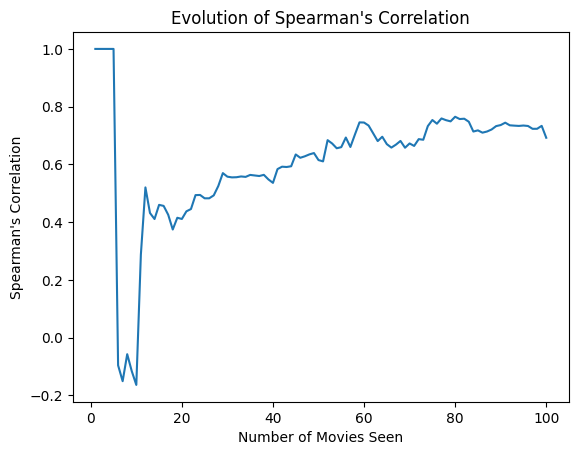

In [54]:
theta = np.random.normal(0, 1, size=len(movies.columns) - 1)
last_weights = theta
correlations = simulate_interaction(theta, n_interactions=100)


plt.plot(range(1, len(correlations) + 1), correlations)
plt.xlabel("Number of Movies Seen")
plt.ylabel("Spearman's Correlation")
plt.title("Evolution of Spearman's Correlation")
plt.show()


The algorithm demonstrates a steady improvement in recommendation quality, as seen in the evolution of Spearman's correlation, which increases and stabilizes around 0.8 after approximately 60 movies. Early stages show instability and negative correlation, reflecting the model's lack of sufficient training data at the beginning. The predicted top-3 genres (Crime, Drama, Animation) partially overlap with the true top-3 genres (Animation, Music, Musical), indicating some alignment with user preferences but room for further improvement. Similarly, the predicted bottom-3 genres (Sci-Fi, Adventure, Mystery) overlap with two of the true bottom-3 genres (Documentary, Mystery, Sci-Fi). Overall, the algorithm captures user preferences reasonably well, showing its potential for more accurate predictions with more data.

In [32]:
actors = pd.DataFrame(mlb.fit_transform(catalogue['Actors']), columns=mlb.classes_)
actors = actors.assign(like=None)

In [33]:
actors

,A. Russell Andrews,A.J. Cook,Aamir Khan,Aaron Eckhart,Aaron Paul,Aaron Ruell,Aaron Stanford,Aaron Taylor-Johnson,Aaron Yoo,Aasif Mandvi,...,Zachery Ty Bryan,Ziyi Zhang,Zoe Saldana,Zoe Salmon,Zoey Vargas,Zoltán Mucsi,Zooey Deschanel,Zoë Bell,Zoë Kravitz,like
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
1033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
1034,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
1035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None


In [34]:
def select_bayes_act():    
    global last_weights
    if set(actors.like) == {True, False, None}:
        # Step 1
        model = LogisticRegression(fit_intercept=False, C=0.1) 
        train_data = actors[actors['like'].notna()]
        X = train_data.drop(['like'], axis=1) 
        y = train_data['like']

        X = X.astype(int)
        y = y.astype(int)
        
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        model.fit(X, y)
        weights_mean = model.coef_[0]
        last_weights = weights_mean
        
        # Step 2
        weights_cov = np.diag([0.1] * len(weights_mean)) 
        sampled_weights = np.random.multivariate_normal(weights_mean, weights_cov)

        # Step 3
        unseen_actors = actors[movies.like.isnull()]  
        X_unseen = unseen_actors.drop(['like'], axis=1).astype(int)
   
        scores = X_unseen.dot(sampled_weights)
        top_movie_idx = np.argmax(scores)
        
        return top_movie_idx 
    
    else:    
        return select_random_movie() 

In [35]:
def simulate_interaction_act(theta, n_interactions=50):
    global movie_id
    global last_weights
    correlations = []
    true_scores, theta = adjust_theta(theta, actors.drop(['like'], axis=1))

    for _ in range(n_interactions):
        current_movie_features = actors.loc[movie_id].drop('like').values
        feedback = simulate_response(theta, current_movie_features)
        actors.at[movie_id, 'like'] = feedback

        unseen_actors = actors[actors['like'].isnull()]
        if len(unseen_actors) > 1:
            predicted_scores = unseen_actors.drop(['like'], axis=1).dot(last_weights)
            true_ranks = true_scores[unseen_actors.index]
            pred_ranks = predicted_scores[unseen_actors.index]
            correlation = spearmanr(true_ranks, pred_ranks).correlation
            correlations.append(correlation)

        movie_id = select_bayes_act()

    genre_names = actors.drop(['like'], axis=1).columns.tolist()

    predicted_top_3, predicted_bottom_3 = get_top_bottom_genres(last_weights, genre_names)
    print("Predicted Top-3 Genres:", predicted_top_3)
    print("Predicted Bottom-3 Genres:", predicted_bottom_3)

    true_top_3, true_bottom_3 = get_top_bottom_genres(theta, genre_names)
    print("True Top-3 Genres:", true_top_3)
    print("True Bottom-3 Genres:", true_bottom_3)

    return correlations


def get_top_bottom_genres(weights, genre_names):
    sorted_indices = np.argsort(weights)  
    top_3_indices = sorted_indices[-3:][::-1] 
    bottom_3_indices = sorted_indices[:3] 

    top_3_genres = [genre_names[i] for i in top_3_indices]
    bottom_3_genres = [genre_names[i] for i in bottom_3_indices]

    return top_3_genres, bottom_3_genres


def adjust_theta(theta, movie_features, target_range=(0.1, 0.9)):
    true_scores = movie_features.dot(theta)
    probabilities = 1 / (1 + np.exp(-true_scores)) 

    like_fraction = np.mean(probabilities > 0.5)

    while like_fraction < target_range[0] or like_fraction > target_range[1]:
        theta = np.random.normal(0, 1, size=len(theta))  
        true_scores = movie_features.dot(theta)
        probabilities = 1 / (1 + np.exp(-true_scores))
        like_fraction = np.mean(probabilities > 0.5)
       
    return true_scores, theta

def simulate_response(theta, movie_features):
    q = 1 / (1 + np.exp(-np.dot(theta, movie_features)))
    return np.random.binomial(1, q)

Predicted Top-3 Genres: ['Christian Bale', 'George Clooney', 'Christian Kahrmann']
Predicted Bottom-3 Genres: ['Gerard Butler', 'Gwyneth Paltrow', 'Kevin Spacey']
True Top-3 Genres: ['Martin Donovan', 'Isabelle Fuhrman', 'Amanda Bynes']
True Bottom-3 Genres: ['Billy Burke', 'Jonah Hill', 'Rachel Bilson']


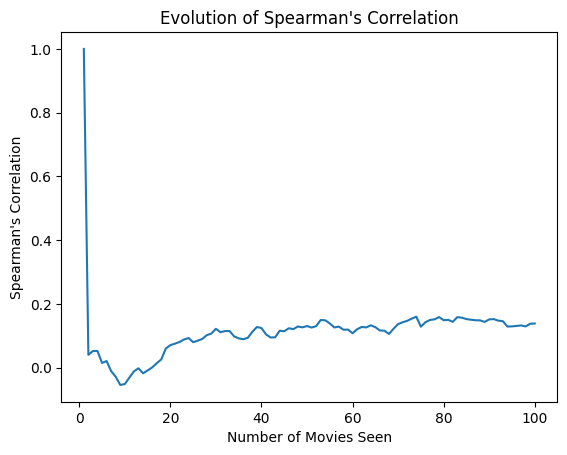

In [38]:
theta_act = np.random.normal(0, 1, size=len(actors.columns) - 1)
last_weights = theta_act
correlations = simulate_interaction_act(theta_act, n_interactions=100)


plt.plot(range(1, len(correlations) + 1), correlations)
plt.xlabel("Number of Movies Seen")
plt.ylabel("Spearman's Correlation")
plt.title("Evolution of Spearman's Correlation")
plt.show()

The results for actors are not very accurate, as the predicted top-3 and bottom-3 actors differ significantly from the true preferences. This is likely due to the large number of actors, making it harder for the model to identify clear patterns. The algorithm may need more data or additional feature filtering to improve accuracy in this category.